In [0]:
# Import necessary libraries for data processing and analysis
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lower, regexp_replace, broadcast
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.classification import NaiveBayes, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.ml.feature import StringIndexer, VectorAssembler
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import re

In [0]:
spark = SparkSession.builder \
    .appName("AmazonReviewsSentimentAnalysis") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.sql.shuffle.partitions", "64") \
    .getOrCreate()

In [0]:
# Load the JSON file containing Amazon reviews into a Spark DataFrame
# Set AWS credentials
spark.conf.set("fs.s3a.access.key", dbutils.secrets.get(scope="aws-secrets", key="access key"))
spark.conf.set("fs.s3a.secret.key", dbutils.secrets.get(scope="aws-secrets", key="secret key"))
spark.conf.set("spark.sql.parquet.compression.codec", "snappy")

# Read the JSON file into a DataFrame
df = spark.read.json('s3://amazon-rewievs-shawon/Video_Games.jsonl')

df.write \
    .mode('overwrite') \
    .option("parquet.compression", "snappy") \
    .parquet('s3://amazon-rewievs-shawon/Video_Games_parquet')

df = spark.read.parquet('s3://amazon-rewievs-shawon/Video_Games_parquet')

df.show(5)

+----------+------------+------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+
|      asin|helpful_vote|images|parent_asin|rating|                text|    timestamp|               title|             user_id|verified_purchase|
+----------+------------+------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+
|B0029LJIFG|           0|    []| B0029LJIFG|   5.0|               Works|1419475888000|               Works|AFA4IZUZO5Q2IE7WE...|             true|
|B001V7QIDY|           0|    []| B001V7QIDY|   5.0|Love the online c...|1419475740000|Whats to say real...|AFA4IZUZO5Q2IE7WE...|             true|
|B00EZV6HHU|           0|    []| B00EZV6HHU|   1.0|Complete waste of...|1404421368000|Save your cash!!!...|AFA4IZUZO5Q2IE7WE...|             true|
|B002VBWIP6|           0|    []| B000N5Z2L4|   5.0|Works and a great...|1363255365000|            It works|AFA4IZUZO5Q

In [0]:
df = df.drop("helpful_vote", "images", "title", "timestamp", "user_id")

df.show(5)

+----------+-----------+------+--------------------+-----------------+
|      asin|parent_asin|rating|                text|verified_purchase|
+----------+-----------+------+--------------------+-----------------+
|B0029LJIFG| B0029LJIFG|   5.0|               Works|             true|
|B001V7QIDY| B001V7QIDY|   5.0|Love the online c...|             true|
|B00EZV6HHU| B00EZV6HHU|   1.0|Complete waste of...|             true|
|B002VBWIP6| B000N5Z2L4|   5.0|Works and a great...|             true|
|B00KTNSKZU| B00KTORA0K|   2.0|By far the worst ...|            false|
+----------+-----------+------+--------------------+-----------------+
only showing top 5 rows



In [0]:
# Clean the data by removing duplicates and selecting relevant columns
# Count the number of rows
row_count = df.count()
print(f"The number of rows in the DataFrame is: {row_count}")

# Drop duplicates across all columns
df = df.dropDuplicates()

# Count the number of rows
row_count2 = df.count()
print(f"The number of rows in the DataFrame after dropping duplicates is: {row_count2}")

The number of rows in the DataFrame is: 4624615
The number of rows in the DataFrame after dropping duplicates is: 4517122


In [0]:
# Remove special characters and convert to lowercase
df = df.withColumn("cleaned_review", lower(regexp_replace(col("text"), r"[^a-zA-Z0-9\s]", "")))

df.show(5)

+----------+-----------+------+--------------------+-----------------+--------------------+
|      asin|parent_asin|rating|                text|verified_purchase|      cleaned_review|
+----------+-----------+------+--------------------+-----------------+--------------------+
|B001I2H6XI| B001I2H6XI|   5.0|        As discribed|             true|        as discribed|
|B08MFH6V6C| B08ZXKMYRL|   5.0|fits better on my...|             true|fits better on my...|
|B077MHTFNH| B077MHTFNH|   5.0|works great charg...|             true|works great charg...|
|B0090ON0U4| B009IJB08A|   5.0|As far as I know ...|             true|as far as i know ...|
|B0136JP9OS| B0136JP9OS|   5.0| My husband livedit!|             true|  my husband livedit|
+----------+-----------+------+--------------------+-----------------+--------------------+
only showing top 5 rows



In [0]:
# Add a sentiment column: 1 for positive reviews, 0 for negative reviews
# Create binary sentiment labels based on rating
df = df.withColumn("sentiment", 
    when(col("rating") >= 4.0, 1.0)
    .otherwise(0.0)
)

In [0]:
df.show(5)
df.unpersist() # Clear cache

+----------+-----------+------+--------------------+-----------------+--------------------+---------+
|      asin|parent_asin|rating|                text|verified_purchase|      cleaned_review|sentiment|
+----------+-----------+------+--------------------+-----------------+--------------------+---------+
|B002EZLP4E| B002JTX9WQ|   2.0|I'm not sure at t...|            false|im not sure at th...|      0.0|
|B09WC3DX9Q| B0086VPUHI|   5.0|Ordered for grand...|             true|ordered for grand...|      1.0|
|B07WZTG9G6| B07WZTG9G6|   5.0|This holder is gr...|             true|this holder is gr...|      1.0|
|B00Y09G6H8| B00Y09G6H8|   5.0|Most amazing head...|            false|most amazing head...|      1.0|
|B07SL6ZXBL| B087NNZZM8|   5.0|my wife super lov...|             true|my wife super lov...|      1.0|
+----------+-----------+------+--------------------+-----------------+--------------------+---------+
only showing top 5 rows



DataFrame[asin: string, parent_asin: string, rating: double, text: string, verified_purchase: boolean, cleaned_review: string, sentiment: double]

In [0]:
# Text preprocessing pipeline
tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="raw_features")
idf = IDF(inputCol="raw_features", outputCol="features")

In [0]:
# Split the data
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [0]:
# Train a machine learning model using Spark MLlib
# Initialize models
nb_model = NaiveBayes(labelCol="sentiment", featuresCol="features")
rf_model = RandomForestClassifier(labelCol="sentiment", featuresCol="features", numTrees=100)
dt_model = DecisionTreeClassifier(labelCol="sentiment", featuresCol="features")

In [0]:
# Create pipelines for each model
nb_pipeline = Pipeline(stages=[
    tokenizer,
    remover,
    vectorizer,
    idf,
    nb_model
])

rf_pipeline = Pipeline(stages=[
    tokenizer,
    remover,
    vectorizer,
    idf,
    rf_model
])

dt_pipeline = Pipeline(stages=[
    tokenizer,
    remover,
    vectorizer,
    idf,
    dt_model
])

In [0]:
# Train models
print("Training Naive Bayes model...")
nb_model_fitted = nb_pipeline.fit(train_data)

print("Training Random Forest model...")
rf_model_fitted = rf_pipeline.fit(train_data)

print("Training Decision Tree model...")
dt_model_fitted = dt_pipeline.fit(train_data)

Training Naive Bayes model...
Training Random Forest model...
Training Decision Tree model...


In [0]:
# Make predictions
nb_predictions = nb_model_fitted.transform(test_data)
rf_predictions = rf_model_fitted.transform(test_data)
dt_predictions = dt_model_fitted.transform(test_data)

In [0]:
# Clean the data by removing duplicates and selecting relevant columns
# Function to evaluate model
def evaluate_model(predictions, model_name):
    evaluator = MulticlassClassificationEvaluator(
        labelCol="sentiment", 
        predictionCol="prediction", 
        metricName="accuracy"
    )
    
    accuracy = evaluator.evaluate(predictions)
    
    # Convert to pandas for detailed metrics
    pd_predictions = predictions.select("sentiment", "prediction").toPandas()
    
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nDetailed Classification Report:")
    print(classification_report(
        pd_predictions["sentiment"],
        pd_predictions["prediction"],
        target_names=["Negative", "Positive"]
    ))
    
    return accuracy

In [0]:
# Evaluate the trained model's performance and compute accuracy
# Evaluate models
print("\nEvaluating models...")
nb_accuracy = evaluate_model(nb_predictions, "Naive Bayes")
rf_accuracy = evaluate_model(rf_predictions, "Random Forest")
dt_accuracy = evaluate_model(dt_predictions, "Decision Tree")


Evaluating models...

Naive Bayes Results:
Accuracy: 0.8564

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.70      0.79      0.74    233393
    Positive       0.92      0.88      0.90    669384

    accuracy                           0.86    902777
   macro avg       0.81      0.83      0.82    902777
weighted avg       0.86      0.86      0.86    902777


Random Forest Results:
Accuracy: 0.7415

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00    233393
    Positive       0.74      1.00      0.85    669384

    accuracy                           0.74    902777
   macro avg       0.37      0.50      0.43    902777
weighted avg       0.55      0.74      0.63    902777


Decision Tree Results:
Accuracy: 0.7632

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.66      0.17      0.28    23

In [0]:
# Compare models
models_accuracy = {
    "Naive Bayes": nb_accuracy,
    "Random Forest": rf_accuracy,
    "Decision Tree": dt_accuracy
}

best_model = max(models_accuracy.items(), key=lambda x: x[1])
print(f"\nBest performing model: {best_model[0]} with accuracy: {best_model[1]:.4f}")


Best performing model: Naive Bayes with accuracy: 0.8564


In [0]:
# Import necessary libraries for data processing and analysis
from datetime import datetime

In [0]:
# Save the best model
s3_bucket = "amazon-rewievs-shawon" 
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
best_model_path = f"s3://{s3_bucket}/best_model_{timestamp}"

if best_model[0] == "Naive Bayes":
    nb_model_fitted.save(best_model_path)
elif best_model[0] == "Random Forest":
    rf_model_fitted.save(best_model_path)
else:
    dt_model_fitted.save(best_model_path)

In [0]:
# Clean the data by removing duplicates and selecting relevant columns
# Example of using the best model for prediction
def predict_sentiment(text, model):
    # Create a temporary DataFrame with the input text
    test_df = spark.createDataFrame([(text,)], ["text"])
    # Make prediction
    prediction = model.transform(test_df)
    return prediction.select("prediction").collect()[0][0]

In [0]:
# Example usage
sample_text = "This product is amazing!"
if best_model[0] == "Naive Bayes":
    prediction = predict_sentiment(sample_text, nb_model_fitted)
elif best_model[0] == "Random Forest":
    prediction = predict_sentiment(sample_text, rf_model_fitted)
else:
    prediction = predict_sentiment(sample_text, dt_model_fitted)

print(f"\nSample prediction for '{sample_text}': {['Negative', 'Positive'][int(prediction)]}")


Sample prediction for 'This product is amazing!': Positive


In [0]:
# Load the saved pipeline model
s3_bucket = "amazon-rewievs-shawon" 
model_path = f"s3://{s3_bucket}/best_model_20241125_155544/"

# Load the model directly
model = PipelineModel.load(model_path)
predictions_df = model.transform(train_data)
predictions_df.cache()
predictions_df.show(10)

+----------+-----------+------+--------------------+-----------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|      asin|parent_asin|rating|                text|verified_purchase|      cleaned_review|sentiment|               words|      filtered_words|        raw_features|            features|       rawPrediction|         probability|prediction|
+----------+-----------+------+--------------------+-----------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|0063052164| 0063052164|   5.0|       I love these!|            false|        i love these|      1.0|   [i, love, these!]|      [love, these!]|(262144,[11,4582]...|(262144,[11,4582]...|[-102.83822343967...|[7.43068145949187...|       1.0|
|0152049495| 0152049495|   5.0|Fun book! Nie

In [0]:
predictions_df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- cleaned_review: string (nullable = true)
 |-- sentiment: double (nullable = false)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- raw_features: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [0]:
# Import necessary libraries for data processing and analysis
from pyspark.sql.types import (
    StructType, StructField, StringType, FloatType, IntegerType, ArrayType, MapType
)

# Define schema
schema = StructType([
    StructField("main_category", StringType(), True),
    StructField("title", StringType(), True),
    StructField("average_rating", FloatType(), True),
    StructField("rating_number", IntegerType(), True),
    StructField("features", ArrayType(StringType()), True),
    StructField("description", ArrayType(StringType()), True),
    StructField("price", FloatType(), True),
    StructField("images", ArrayType(
        StructType([
            StructField("thumb", StringType(), True),
            StructField("large", StringType(), True),
            StructField("variant", StringType(), True),
            StructField("hi_res", StringType(), True),
        ])
    ), True),
    StructField("videos", ArrayType(StringType()), True),
    StructField("store", StringType(), True),
    StructField("categories", ArrayType(StringType()), True),
    StructField("details", StructType([
        StructField("Release date", StringType(), True),
        StructField("Best Sellers Rank", MapType(StringType(), IntegerType()), True),
        StructField("Pricing", StringType(), True),
        StructField("Package Dimensions", StringType(), True),
        StructField("Type of item", StringType(), True),
        StructField("Rated", StringType(), True),
        StructField("Item model number", StringType(), True),
        StructField("Is Discontinued By Manufacturer", StringType(), True),
        StructField("Item Weight", StringType(), True),
        StructField("Manufacturer", StringType(), True),
        StructField("Date First Available", StringType(), True),
    ]), True),
    StructField("parent_asin", StringType(), True),
    StructField("bought_together", StringType(), True),
])

meta_data_df = spark.read.schema(schema).json('s3://amazon-rewievs-shawon/meta_Video_Games.jsonl')

meta_data_df.write \
    .mode('overwrite') \
    .option("parquet.compression", "snappy") \
    .parquet('s3://amazon-rewievs-shawon/meta_data_parquet')

meta_data_df = spark.read.parquet('s3://amazon-rewievs-shawon/meta_data_parquet')
meta_data_df.show(5)


+---------------+--------------------+--------------+-------------+---------------------+--------------------+-----+--------------------+--------------------+-----------+--------------------+--------------------+-----------+---------------+
|  main_category|               title|average_rating|rating_number|             features|         description|price|              images|              videos|      store|          categories|             details|parent_asin|bought_together|
+---------------+--------------------+--------------+-------------+---------------------+--------------------+-----+--------------------+--------------------+-----------+--------------------+--------------------+-----------+---------------+
|    Video Games|Kane and Lynch 2:...|           4.0|           35|                   []|[Product Descript...| 7.72|[{https://m.media...|[{"title": "Kane ...|Square Enix|[Video Games, PC,...|{August 17, 2010,...| B0023B14WC|           NULL|
|    Video Games|Dreamscapes The S..

In [0]:
meta_data_df.printSchema()

root
 |-- main_category: string (nullable = true)
 |-- title: string (nullable = true)
 |-- average_rating: float (nullable = true)
 |-- rating_number: integer (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- price: float (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- thumb: string (nullable = true)
 |    |    |-- large: string (nullable = true)
 |    |    |-- variant: string (nullable = true)
 |    |    |-- hi_res: string (nullable = true)
 |-- videos: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- store: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- details: struct (nullable = true)
 |    |-- Release date: string (nullable = true)
 |    |-- Best Sellers Rank: map (

In [0]:
meta_data_df = meta_data_df.drop("helpful_vote", "images", "timestamp", "user_id")

In [0]:
# Drop rows with null `parent_asin` in both DataFrames
predictions_df = predictions_df.dropna(subset=["parent_asin"])
meta_data_df = meta_data_df.dropna(subset=["parent_asin"])


In [0]:
# Perform broadcast join
joined_df = predictions_df.join(broadcast(meta_data_df), "parent_asin")
joined_df.cache()

predictions_df.unpersist()

# Show the joined schema and sample rows
joined_df.printSchema()

root
 |-- parent_asin: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- cleaned_review: string (nullable = true)
 |-- sentiment: double (nullable = false)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- raw_features: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)
 |-- main_category: string (nullable = true)
 |-- title: string (nullable = true)
 |-- average_rating: float (nullable = true)
 |-- rating_number: integer (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- 

In [0]:
joined_df.show(5)

+-----------+----------+------+--------------------+-----------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+-------------+--------------------+--------------+-------------+--------------------+--------------------+-----+------+--------------------+--------------------+--------------------+---------------+
|parent_asin|      asin|rating|                text|verified_purchase|      cleaned_review|sentiment|               words|      filtered_words|        raw_features|            features|       rawPrediction|         probability|prediction|main_category|               title|average_rating|rating_number|            features|         description|price|videos|               store|          categories|             details|bought_together|
+-----------+----------+------+--------------------+-----------------+--------------------+---------+--------------------+----

In [0]:
# Filter positive sentiment
positive_sentiment = joined_df.filter(joined_df.prediction == 1)

# Count positive reviews per product
positive_products = positive_sentiment.groupBy("main_category").count().orderBy("count", ascending=False)
positive_products.show()


+--------------------+-------+
|       main_category|  count|
+--------------------+-------+
|         Video Games|1616530|
|           Computers| 445917|
|     All Electronics| 294191|
|Cell Phones & Acc...|  60295|
|                NULL|  43789|
|        Toys & Games|  20338|
|Industrial & Scie...|   9428|
|            Software|   9418|
|        Buy a Kindle|   7458|
|         Amazon Home|   6910|
|               Books|   5476|
|Home Audio & Theater|   4934|
|Tools & Home Impr...|   4845|
|         Movies & TV|   3516|
|     Office Products|   3337|
|      Amazon Devices|   3169|
|             Grocery|   2963|
|   Sports & Outdoors|   2286|
|      Camera & Photo|   1450|
|       Digital Music|   1049|
+--------------------+-------+
only showing top 20 rows



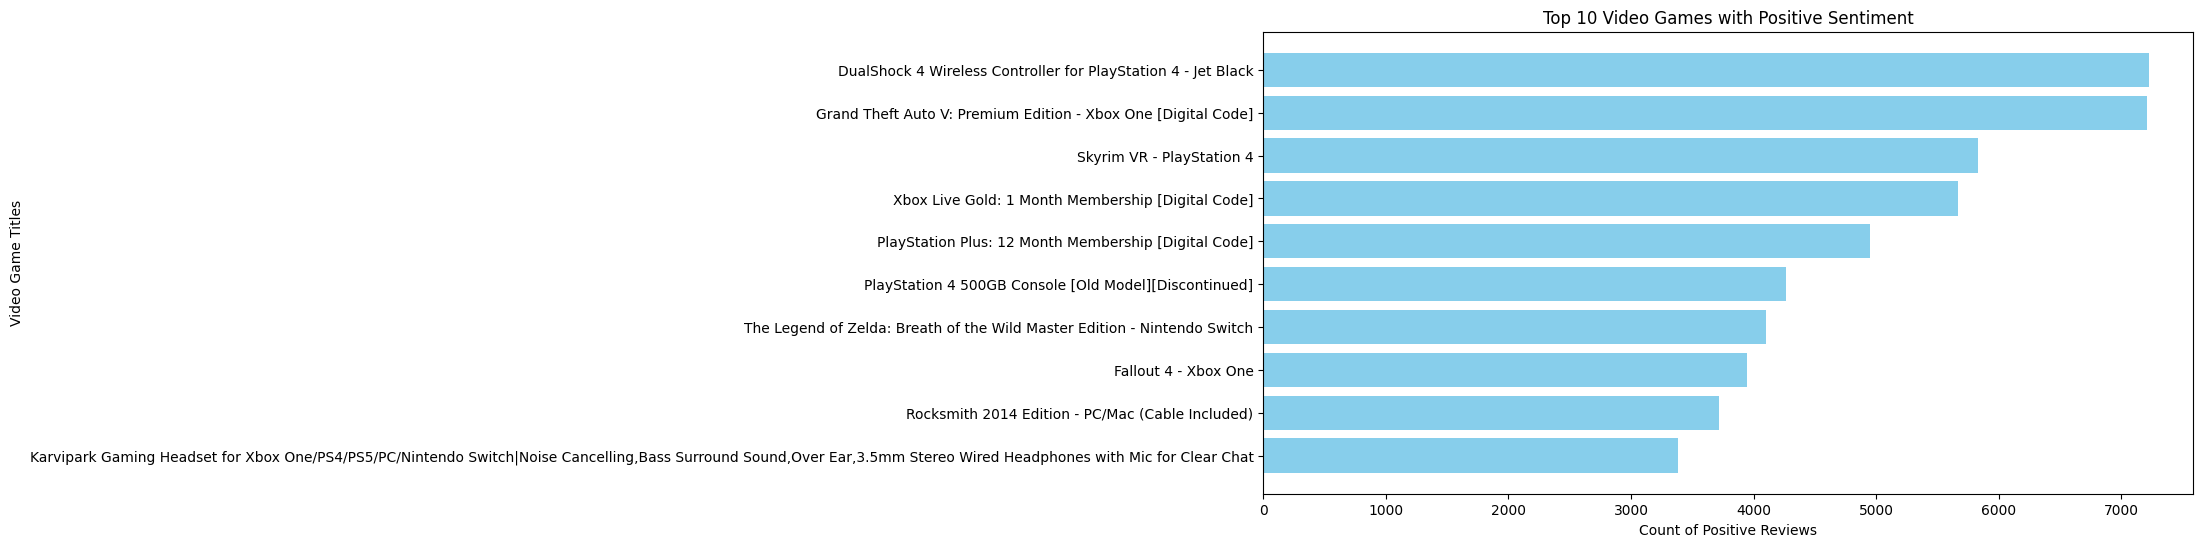

In [0]:
# Import necessary libraries for data processing and analysis
# Filter positive sentiment and main category as "Video Games"
positive_sentiment = joined_df.filter((joined_df.prediction == 1) & (joined_df.main_category == "Video Games"))

# Count positive reviews per product
positive_products = positive_sentiment.groupBy("title").count().orderBy("count", ascending=False)

# Limit the top 10 video games with positive sentiment
top_positive_video_games = positive_products.limit(10).toPandas()

# Extract data for plotting
titles = top_positive_video_games["title"]
counts = top_positive_video_games["count"]

# Create the bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.barh(titles, counts, color="skyblue")
plt.xlabel("Count of Positive Reviews")
plt.ylabel("Video Game Titles")
plt.title("Top 10 Video Games with Positive Sentiment")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


In [0]:
# Filter data for Video Games category
video_games_df = joined_df.filter(joined_df.main_category == "Video Games")

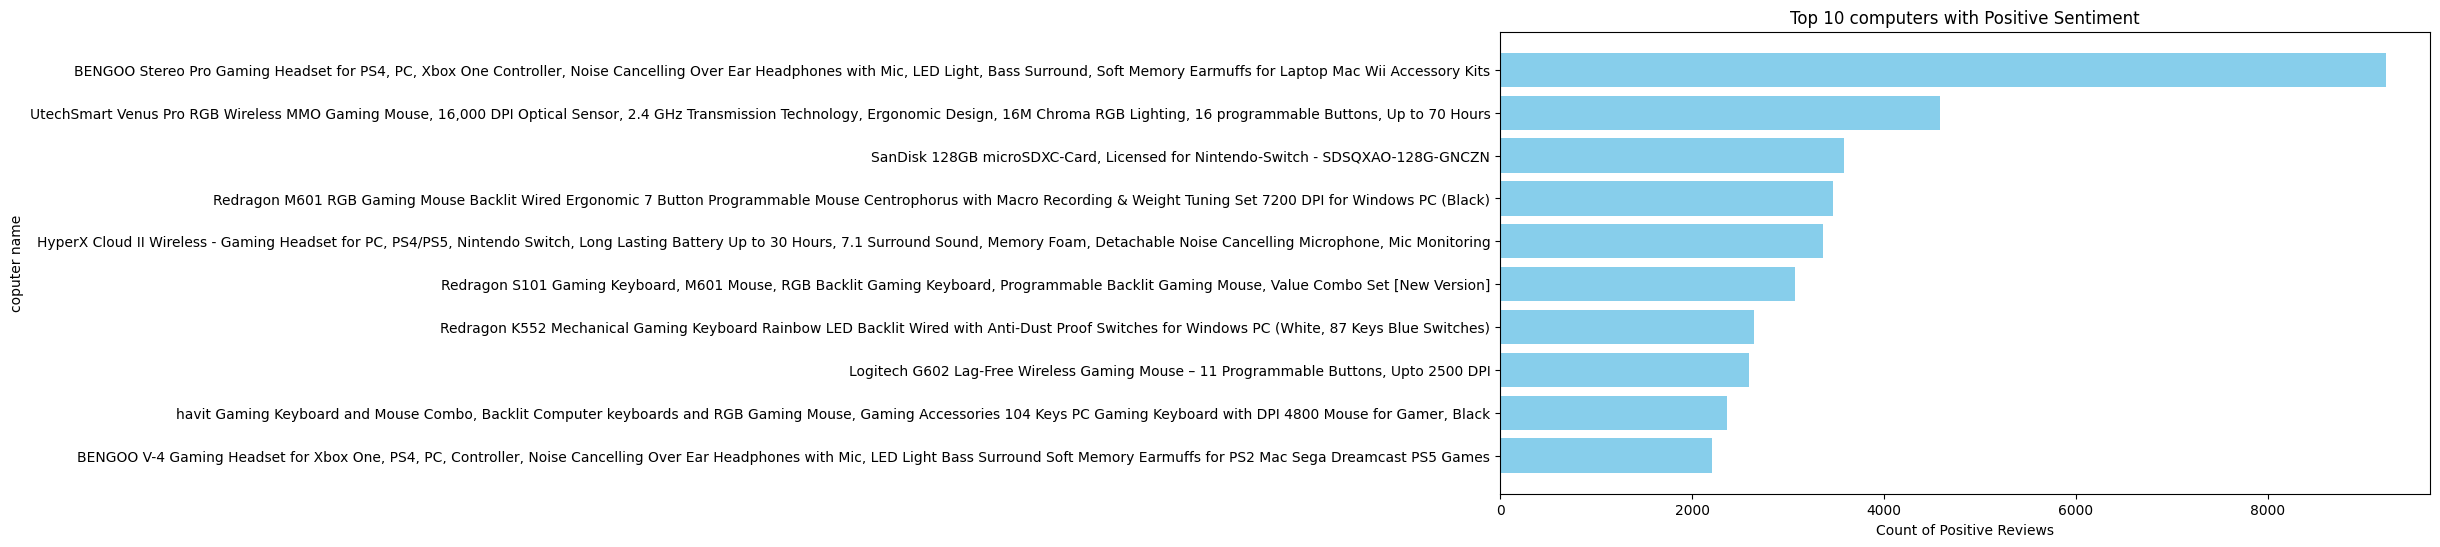

In [0]:
# Import necessary libraries for data processing and analysis
# Filter positive sentiment and main category as "Video Games"
positive_sentiment = joined_df.filter((joined_df.prediction == 1) & (joined_df.main_category == "Computers"))

# Count positive reviews per product
positive_products = positive_sentiment.groupBy("title").count().orderBy("count", ascending=False)

# Limit the top 10 video games with positive sentiment
top_positive_video_games = positive_products.limit(10).toPandas()

# Extract data for plotting
titles = top_positive_video_games["title"]
counts = top_positive_video_games["count"]

# Create the bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.barh(titles, counts, color="skyblue")
plt.xlabel("Count of Positive Reviews")
plt.ylabel("coputer name")
plt.title("Top 10 computers with Positive Sentiment")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

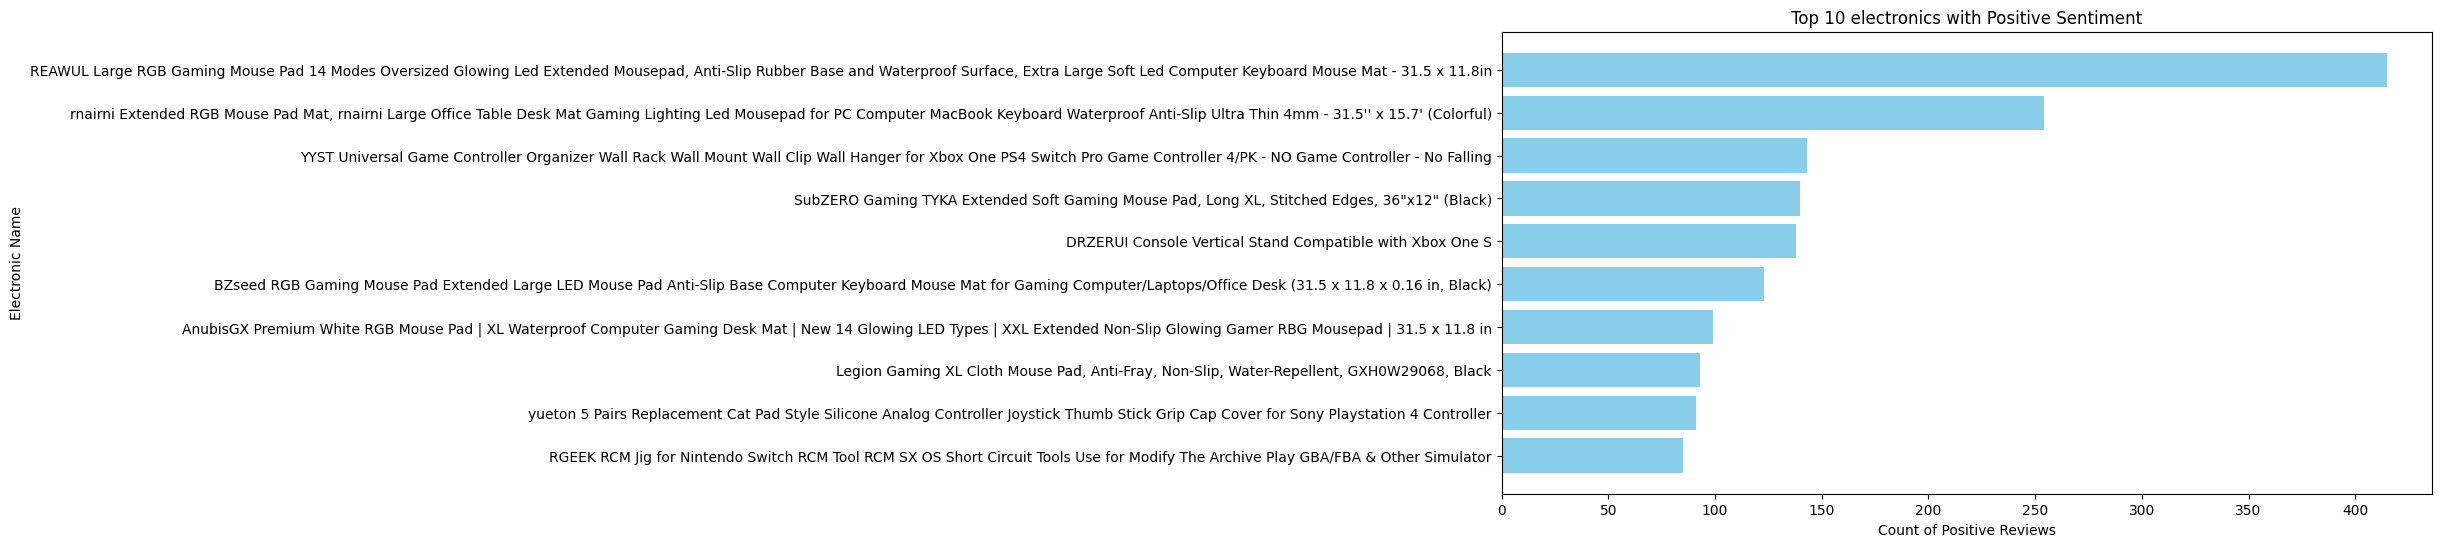

In [0]:
# Import necessary libraries for data processing and analysis
# Filter positive sentiment and main category as "Video Games"
positive_sentiment = joined_df.filter((joined_df.prediction == 1) & (joined_df.main_category == "Office Products"))

# Count positive reviews per product
positive_products = positive_sentiment.groupBy("title").count().orderBy("count", ascending=False)

# Limit the top 10 video games with positive sentiment
top_positive_video_games = positive_products.limit(10).toPandas()

# Extract data for plotting
titles = top_positive_video_games["title"]
counts = top_positive_video_games["count"]

# Create the bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.barh(titles, counts, color="skyblue")
plt.xlabel("Count of Positive Reviews")
plt.ylabel("Electronic Name")
plt.title("Top 10 electronics with Positive Sentiment")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()